## TME 3

In [1]:
from arftools import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
import os


## Fonctions d'erreur

In [2]:
def mse(datax,datay,w):
    """ retourne la moyenne de l'erreur aux moindres carres """
    func = w.dot(datax.transpose())
    y = datay.flatten()
    return np.sum((y-func)**2)/len(datax)

def mse_g(datax,datay,w):
    """ retourne le gradient moyen de l'erreur au moindres carres """
    prodScal = w.dot(trainx.transpose())
    diff = datay.flatten() - prodScal.flatten()
    res=np.array([(2/len(datax))*np.vdot(-datax[:,i],diff) for i in range (len(w))])
    return res

def hinge(datax,datay,w):
    """ retourn la moyenne de l'erreur hinge """
    res=0
    a = -datay
    b = datax.dot(w.transpose())
    for i in range(len(a)):
        temp = a[i]*b[i]
        if temp>0:
            res+=temp
    return res

def hinge_g(datax,datay,w):
    """ retourne le gradient moyen de l'erreur hinge """
    prodScal = datax.dot(w.transpose())
    res=np.zeros(w.shape)
    for i in range(len(datay)):
        if datay[i]*prodScal[i] < 0:
            res += -datay[i]*datax[i]
    return res/len(datax)


## Classifieur linéaire

In [3]:
class Lineaire(object):
    def __init__(self,loss=hinge,loss_g=hinge_g,max_iter=1000,eps=0.01):
        """ :loss: fonction de cout
            :loss_g: gradient de la fonction de cout
            :max_iter: nombre d'iterations
            :eps: pas de gradient
        """
        self.max_iter, self.eps = max_iter,eps
        self.loss, self.loss_g = loss, loss_g
        self.arrayError=[]

    def fit(self,datax,datay,testx=None,testy=None,type_d="batch"):
        """ :datax: donnees de train
            :datay: label de train
            :testx: donnees de test
            :testy: label de test
        """
        # on transforme datay en vecteur colonne
        datay = datay.reshape(-1,1)
        N = len(datay)
        datax = datax.reshape(N,-1)
        D = datax.shape[1]
        self.w = np.random.random((1,D))
        if (type_d=="stochastique"):
            for i in range(self.max_iter):
                self.arrayError.append(self.loss(datax,datay,self.w))
                for j in range(0,len(datax)):
                    x=datax[j].reshape(1,-1)
                    y=datay[j].reshape(1,-1)
                    self.w=self.w-self.eps*self.loss_g(x,y,self.w)
        else:
            for i in range(self.max_iter):
                self.arrayError.append(self.loss(datax,datay,self.w))
                self.w=self.w-self.eps*self.loss_g(datax,datay,self.w)
                


    def predict(self,datax):
        if len(datax.shape)==1:
            datax = datax.reshape(1,-1)
        return np.array([np.sign(self.w.dot(datax[i])) for i in range(len(datax))])

    def score(self,datax,datay):
        prediction = self.predict(datax).flatten()
        accuracy = len(np.where(prediction==datay)[0])
        return accuracy/len(datax)

    def predictPoly(self,datax):
        datax = transformeData(datax)
        if len(datax.shape)==1:
            datax = datax.reshape(1,-1)
        return np.array([np.sign(self.w.dot(datax[i])) for i in range(len(datax))])

## Problème bi-classe

In [4]:
def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")

def plot_error(datax,datay,f,step=10):
    grid,x1list,x2list=make_grid(xmin=-4,xmax=4,ymin=-4,ymax=4)
    plt.contourf(x1list,x2list,np.array([f(datax,datay,w) for w in grid]).reshape(x1list.shape),25)
    plt.colorbar()
    plt.show()


def getTwoTrainTestUsps(datax,datay,number1,number2):
    where1 = np.where(datay == number1)[0]
    where2 = np.where(datay == number2)[0]
    train1 = datax[where1]
    train2 = datax[where2]
    label1 = np.array([1 for i in range(len(where1))])
    label2 = np.array([-1 for i in range(len(where2))])
    trainx = np.append(train1, train2, axis=0)
    trainy = np.append(label1, label2, axis=0)
    c = list(zip(trainx, trainy))
    np.random.shuffle(c)
    trainx, trainy = zip(*c)
    trainx = np.array(trainx)
    trainy = np.array(trainy)
    return trainx, trainy

def transformeData(data):
    return np.array([[1,x,y,x**2,y**2,x*y] for x,y in data])

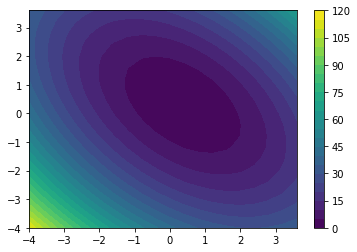

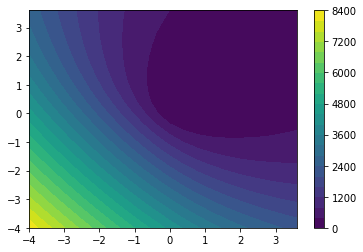

Erreur : train 0.919000, test 0.923000


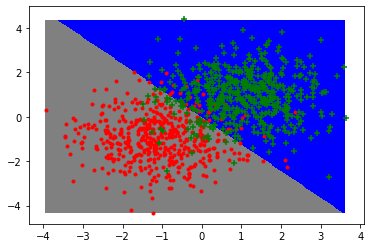

In [48]:
plt.ion()
trainx,trainy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
testx,testy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
plt.figure()
plot_error(trainx,trainy,mse)
plt.figure()
plot_error(trainx,trainy,hinge)

perceptron = Lineaire(hinge, hinge_g, max_iter=1000, eps=0.1)
perceptron.fit(trainx, trainy)
print("Erreur : train %f, test %f" % (perceptron.score(trainx, trainy), perceptron.score(testx, testy)))
plt.figure()
plot_frontiere(trainx,perceptron.predict,200)
plot_data(trainx,trainy)

Le perceptron marche très bien sur des données linéairement séparables.

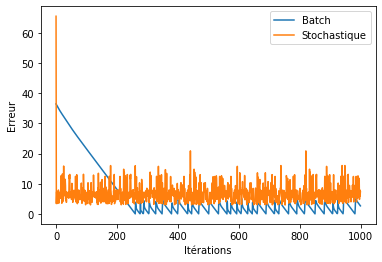

In [55]:
x = np.arange(0,1000,1)
perceptron = Lineaire(hinge, hinge_g, max_iter=1000, eps=0.1)
perceptron.fit(trainx, trainy)
errorBatch = plt.plot(x,perceptron.arrayError,label="Batch")
perceptron = Lineaire(hinge, hinge_g, max_iter=1000, eps=0.1)
perceptron.fit(trainx, trainy,type_d="stochastique")
errorStoch = plt.plot(x,perceptron.arrayError,label="Stochastique")
plt.xlabel("Itérations")
plt.ylabel("Erreur")
plt.legend()

On remarque que la descente de gradient stochastique converge bien plus rapidement que l'algorithme classique. Cependant, ce dernier converge vers un meilleur minimum.

In [31]:
datax, datay = load_usps("USPS/usps_train.txt")
trainx, trainy = getTwoTrainTestUsps(datax,datay,3,1)
dataxTest, datayTest = load_usps("USPS/usps_test.txt")
testx,testy = getTwoTrainTestUsps(dataxTest,datayTest,3,1)

perceptron = Lineaire(hinge, hinge_g, max_iter=1000, eps=0.1)
perceptron.fit(trainx, trainy)
print("Erreur : train %f, test %f" % (perceptron.score(trainx, trainy), perceptron.score(testx, testy)))

Erreur : train 0.998797, test 0.993023


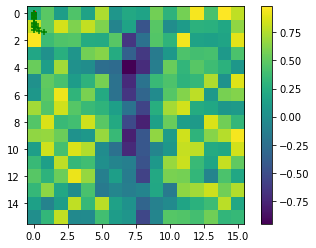

In [22]:
plt.figure()
plot_data(trainx, trainy)
plt.imshow(perceptron.w.reshape((16, 16)))
plt.colorbar()

On distingue une forme de "1" qui se dégage, ce qui est cohérent avec les données d'apprentissage

## Classifieur polynomial

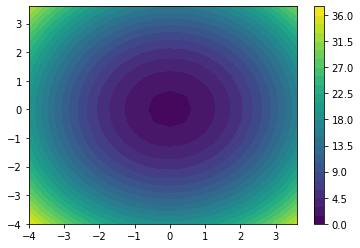

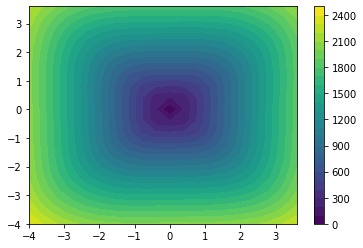

Erreur : train 0.501000, test 0.494000


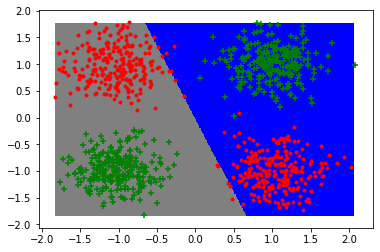

In [5]:
plt.ion()
e = 0.02
trainx,trainy =  gen_arti(nbex=1000,data_type=1,epsilon=0.02)
testx,testy =  gen_arti(nbex=1000,data_type=1,epsilon=0.02)
plt.figure()
plot_error(trainx,trainy,mse)
plt.figure()
plot_error(trainx,trainy,hinge)

perceptron = Lineaire(hinge, hinge_g, max_iter=1000, eps=0.1)
perceptron.fit(trainx, trainy)
print("Erreur : train %f, test %f" % (perceptron.score(trainx, trainy), perceptron.score(testx, testy)))
plt.figure()
plot_frontiere(trainx,perceptron.predict,200)
plot_data(trainx,trainy)

Le perceptron n'est pas performant sur des données non linéairement séparables.
En effet, on tente de séparer des données non linéairement séparables avec une droite: On obtient des scores de 50% et il faut changer la représentation des données si l'on veut obtenir de meilleurs scores

Pour cela, on peut effectuer une projection polynomiale.

Erreur : train 0.997000, test 0.990000


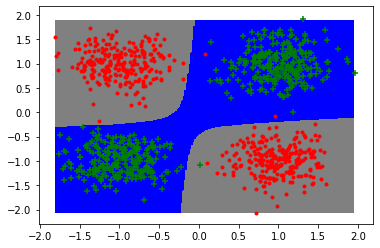

In [43]:
e = 0.02
trainx,trainy = gen_arti(nbex=1000,data_type=1,epsilon=e)
testx,testy =  gen_arti(nbex=1000,data_type=1,epsilon=e)
trainx_t = transformeData(trainx)
testx_t = transformeData(testx)
perceptron = Lineaire(hinge, hinge_g, max_iter=1000, eps=0.1)
perceptron.fit(trainx_t, trainy)
print("Erreur : train %f, test %f" % (perceptron.score(trainx_t, trainy), perceptron.score(testx_t, testy)))

plt.figure()
plot_frontiere(trainx,perceptron.predictPoly,200)
plot_data(trainx,trainy)

Après la projection polynomiale, les performances sont excellentes.
La projection polynomiale est donc très utile dans le cas de données non linéairement séparables.